# UWIE_MODEL1 : 
# r1 = LOWER_LIMIT ( Optimal Value Determined by DE Algo)
# s1 = 0 
# r2 = UPPER LIMIT ( Optimal Value Determined by DE Algo)
# s2 = 255 

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
# %matplotlib inline
#from tqdm import tqdm_notebook as tqdm
#import time
from scipy.optimize import differential_evolution
from skimage.measure import compare_ssim as ssim
import copy

In [12]:
global itera
itera = 0

In [13]:
def pixelVal(pix, r1, s1, r2, s2): 
    if (0 <= pix and pix <= r1):
        #return 0.0 
        return (s1 / r1)*pix 
    elif (r1 < pix and pix <= r2): 
        return ((s2 - s1)/(r2 - r1)) * (pix - r1) + s1 
    else:
        return ((255 - s2)/(255 - r2)) * (pix - r2) + s2

In [14]:
def mse(x, y):
    return np.linalg.norm(x - y)

In [15]:

#def objectiveFunction(wfull, cumulImageProbDensity,OriginalProbDensity):
def objectiveFunction(wfull, image1, cumulImageProbDensity):
    #print('Hey I am here')
    #global itera
    #itera += 1
    #print('current iteration is ',itera)
    TotalNumberOfPixelsInImage = (image1.shape[0])*(image1.shape[1])
    tempObjValue = 0
    for i in range(0,3):
        w = wfull[i]
        lowerLimit = 0.0
        upperLimit = 255.0
        tempSum = 0
        for j in range(0, 256):
            if(cumulImageProbDensity[i][j] >= w):
                lowerLimit = j
                break
        for j in range(0, 256):
            if(cumulImageProbDensity[i][255-j] <= (1-w)):
                upperLimit = 255.0-j
                break


        if(1):
            a = 0.0
            b = 255.0
            #a = wfull[i+3]
            #b = wfull[i+6]
            #print('lowerLimit and upperLimit in this fun call is  ',w,lowerLimit,upperLimit)
            if(lowerLimit == upperLimit):
                #transformedImage = image[:]
                transformedImage = np.empty((image1.shape[0],image1.shape[1]))
                tempMask1 = (image1[:,:,i] <= lowerLimit)
                tempMask2 = (image1[:,:,i] >= upperLimit)				
                transformedImage[tempMask1] = 0.0#image[tempMask1]#lowerLimit#
                transformedImage[tempMask2] = 255.0#image[tempMask2]#upperLimit#

            else:
                factor = (b-a)/(upperLimit-lowerLimit)
                #transformedImage = image[:]
                transformedImage = np.empty((image1.shape[0],image1.shape[1]))
                if(lowerLimit< upperLimit):
                    tempMask1 = (image1[:,:,i] <= lowerLimit)
                    tempMask2 = (image1[:,:,i] >= upperLimit)				
                else:
                    tempMask1 = (image1[:,:,i] >= lowerLimit)
                    tempMask2 = (image1[:,:,i] <= upperLimit)				
                transformedImage = np.around(a+((image1[:,:,i]-lowerLimit)*factor))
                transformedImage[tempMask1] = 0.0#image[tempMask1]#lowerLimit#
                transformedImage[tempMask2] = 255.0#image[tempMask2]#upperLimit#
                #transformedImage[tempMask1] = np.around((wfull[i+3] / lowerLimit)*image1[:,:,i][tempMask1]) 
                #transformedImage[tempMask2] = np.around(((255 - wfull[i+6])/(255 - upperLimit)) * (image1[:,:,i][tempMask2] - upperLimit) + wfull[i+6])


        if(0):
            pixelVal_vec = np.vectorize(pixelVal) 
            transformedIntensities = pixelVal_vec(range(0,256), lowerLimit, 0, upperLimit, 255)
            NewprobDensity = np.zeros(256)
            for j in range(0,256):
                tempTI = []
                for k in range(0,256):
                    if(int(transformedIntensities[k])==j):
                        tempTI.append(k)
                if(len(tempTI)!=0):
                    for p in tempTI:
                        NewprobDensity[j] +=  OriginalProbDensity[i][p]

        NewprobDensity, _ = np.histogram(transformedImage, 256, [0, 256])
        NewprobDensity = NewprobDensity/TotalNumberOfPixelsInImage

        NonZeroNewProbDensity = NewprobDensity[NewprobDensity > 0]
        entropy = -1*np.sum(NonZeroNewProbDensity*np.log2(NonZeroNewProbDensity))
        dy, dx = np.gradient(transformedImage)
        avg_gradient = np.sum(np.sqrt((dy**2)+(dx**2)))/TotalNumberOfPixelsInImage
        tempObjValue += (entropy+avg_gradient)
        return np.array([-tempObjValue])

In [16]:
def contrastStretching(image, w, s1, s2):
	# compute the histogram
	#print('w in contrastStretching is ',w)
	TotalNumberOfPixelsInImage = (image.shape[0])*(image.shape[1])
	NumberofPixelsPerIntensity = np.zeros(256)
	for i in range(0, 256):
		NumberofPixelsPerIntensity[i] = np.sum(image == i)
	probDensity = NumberofPixelsPerIntensity/TotalNumberOfPixelsInImage
	lowerLimit = 0
	upperLimit = 255
	tempSum = 0
	for i in range(0,256):
		tempSum += probDensity[i]
		if(tempSum>w):
			lowerLimit = i
			break 
	tempSum = 0
	for i in range(0,256):
		tempSum += probDensity[int(255-i)]
		if(tempSum>w):
			upperLimit = int(255-i)
			break
	pixelVal_vec = np.vectorize(pixelVal) 
	# Apply contrast stretching.
	print('w ,lowerLimit, upperLimit are',w,lowerLimit,upperLimit)
	#transformedImage = pixelVal_vec(image, lowerLimit, s1, upperLimit, s2)
	transformedImage = pixelVal_vec(image, lowerLimit, 0, upperLimit, 255)
	transformedImage = np.clip(np.round(transformedImage),0,255)
	return transformedImage


In [20]:
def EnhanceTheImage(GivenImage):
	#BestWforEachChannel = np.zeros(3)
	cumulImageProbDensity1 = []
	probDensity1 = []
	for i in range(0,GivenImage.shape[-1]):
		image = GivenImage[:,:,i]
		TotalNumberOfPixelsInImage = (image.shape[0])*(image.shape[1]) 
		NumberofPixelsPerIntensity = np.zeros(256)
		for j in range(0,256):
			NumberofPixelsPerIntensity[j] = np.sum(image==j)
		probDensity = NumberofPixelsPerIntensity/TotalNumberOfPixelsInImage
		probDensity1.append(probDensity)
		cumulImageProbDensity1.append(np.cumsum(probDensity))

	#if(0):
	#cumulImageProbDensity1 = 5
	lowerBound = 0.0
	upperBound = 0.1
	s1LowerBound = 0.0
	s1UpperBound = 127.0
	s2LowerBound = 128.0
	s2UpperBound = 255.0
	bounds1 = [(lowerBound,upperBound)]*3
	#bounds2 = [(s1LowerBound,s1UpperBound)]*3
	#bounds3 = [(s2LowerBound,s2UpperBound)]*3
	bounds = bounds1#+bounds2+bounds3
	#print('the bounds are ')
	#print(bounds)
	print('starting the DEAlgo')
	#result = differential_evolution(objectiveFunction, bounds,args = (cumulImageProbDensity1,probDensity1),disp = True,strategy = 'best1bin',tol=1e-4,popsize=40,mutation=0.8,recombination = 0.7,maxiter = 200,workers = 5) 
	result = differential_evolution(objectiveFunction, bounds,args = (GivenImage,cumulImageProbDensity1),disp = True,strategy = 'best1bin',tol=0.001,popsize=40,mutation=0.8,recombination = 0.7,maxiter = 100,workers = 1,updating= 'immediate') 
	BestWforEachChannel = result.x

	#print('BestWforEachChannel')
	#print(BestWforEachChannel)

	EnhancedImage = np.zeros(GivenImage.shape)
	for i in range(0,GivenImage.shape[-1]):
		EnhancedImage[:,:,i] = contrastStretching(GivenImage[:,:,i],BestWforEachChannel[i],0,255)
		#EnhancedImage[:,:,i] = contrastStretching(GivenImage[:,:,i],BestWforEachChannel[i],BestWforEachChannel[i+3],BestWforEachChannel[i+6])
	kernel = np.ones((5,5),np.float32)/25
	dst = cv2.filter2D(EnhancedImage,-1,kernel)
	EnhancedImage += (EnhancedImage-dst)
	return np.clip(EnhancedImage,0,255)

In [21]:
def objFunctionValue(GivenImage):
	global histFigNum
	tempObjValue = 0
	tempObjEntropyValue = 0
	tempObjAvg_GradValue = 0
	TotalNumberOfPixelsInImage = (GivenImage.shape[0])*(GivenImage.shape[1])
	for i in range(0,GivenImage.shape[-1]):
		image = GivenImage[:,:,i]
		probDensity, _ = np.histogram(image, 256, [0, 256])
		probDensity = probDensity/TotalNumberOfPixelsInImage
		if(0):
			plt.plot(np.arange(0, 256, 1), probDensity, color='red')
			plt.fill_between(np.arange(0, 256, 1), probDensity, color='red')
			plt.savefig(str(histFigNum)+'thHistogram.jpg')
		histFigNum += 1		
		NonZeroNewProbDensity = probDensity[probDensity > 0]
		entropy = -1*np.sum(NonZeroNewProbDensity*np.log2(NonZeroNewProbDensity))
		#dy, dx = np.gradient(image)
		#avg_gradient = np.sum(np.sqrt((dy**2)+(dx**2)))/TotalNumberOfPixelsInImage
		tempMean = np.sum(range(0,256)*probDensity)
		tempVariance = np.sum(((range(0,256)-tempMean)**2)*probDensity)
		avg_gradient = tempVariance
		tempObjEntropyValue += entropy
		tempObjAvg_GradValue += avg_gradient
		tempObjValue += (entropy+avg_gradient)
	return tempObjValue,tempObjEntropyValue,tempObjAvg_GradValue

GivenImageName UW1.PNG
starting the DEAlgo
differential_evolution step 1: f(x)= -12.4571
differential_evolution step 2: f(x)= -12.4571
differential_evolution step 3: f(x)= -12.4571
differential_evolution step 4: f(x)= -12.4571
differential_evolution step 5: f(x)= -12.4571
w ,lowerLimit, upperLimit are 0.06935585317874103 52 90
w ,lowerLimit, upperLimit are 0.08010581132064645 72 182
w ,lowerLimit, upperLimit are 0.002452025606873097 95 223
Given Image


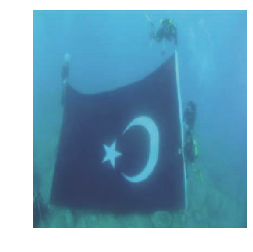

Enhanced Image


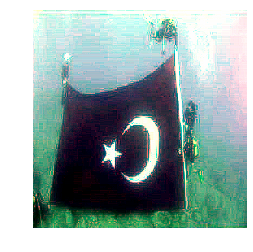

GivenImageName UW2.PNG
starting the DEAlgo
differential_evolution step 1: f(x)= -24.3998
differential_evolution step 2: f(x)= -24.3998
differential_evolution step 3: f(x)= -24.3998
differential_evolution step 4: f(x)= -24.3998
differential_evolution step 5: f(x)= -24.3998
differential_evolution step 6: f(x)= -24.3998
differential_evolution step 7: f(x)= -24.3998
differential_evolution step 8: f(x)= -24.3998
differential_evolution step 9: f(x)= -24.3998
differential_evolution step 10: f(x)= -24.3998
differential_evolution step 11: f(x)= -24.3998
differential_evolution step 12: f(x)= -24.3998
w ,lowerLimit, upperLimit are 0.0996154777419853 81 152
w ,lowerLimit, upperLimit are 0.008987276730435832 101 217
w ,lowerLimit, upperLimit are 0.001916911988384666 77 202
Given Image


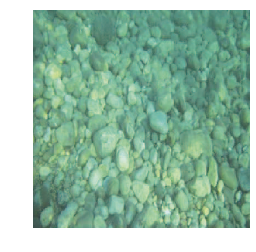

Enhanced Image


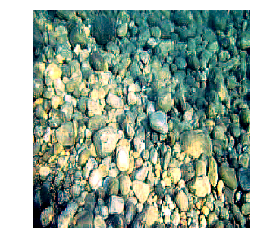

GivenImageName UW3.PNG
starting the DEAlgo
differential_evolution step 1: f(x)= -19.5727
differential_evolution step 2: f(x)= -19.5727
differential_evolution step 3: f(x)= -19.5727
differential_evolution step 4: f(x)= -19.5727
differential_evolution step 5: f(x)= -19.5727
w ,lowerLimit, upperLimit are 0.09523096268756681 57 114
w ,lowerLimit, upperLimit are 0.08392003580451826 123 191
w ,lowerLimit, upperLimit are 0.039858461432498896 115 185
Given Image


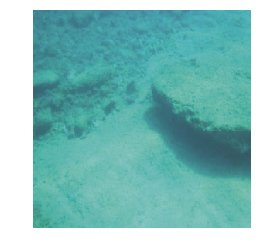

Enhanced Image


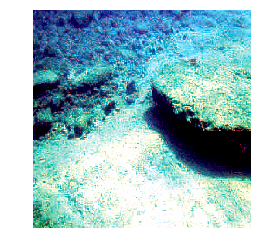

GivenImageName UW4.PNG
starting the DEAlgo
differential_evolution step 1: f(x)= -20.3648
differential_evolution step 2: f(x)= -20.3648
differential_evolution step 3: f(x)= -20.3648
differential_evolution step 4: f(x)= -20.3648
differential_evolution step 5: f(x)= -20.3648
differential_evolution step 6: f(x)= -20.3648
differential_evolution step 7: f(x)= -20.3648
differential_evolution step 8: f(x)= -20.3648
w ,lowerLimit, upperLimit are 0.09324247797803437 48 133
w ,lowerLimit, upperLimit are 0.06085082825852467 69 197
w ,lowerLimit, upperLimit are 0.03056807964338389 61 168
Given Image


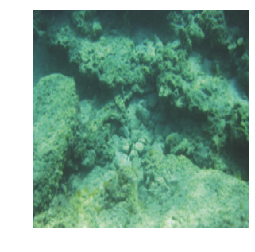

Enhanced Image


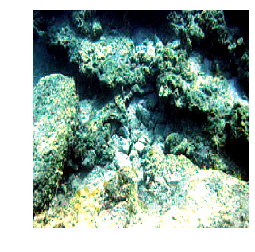

In [30]:
for tempImageName in ["UW1.PNG","UW2.PNG","UW3.PNG","UW4.PNG"]:
    print('GivenImageName',tempImageName)
    tempGivenImage = cv2.imread("PaperImages/"+tempImageName)
    tempGivenImage = cv2.cvtColor(tempGivenImage, cv2.COLOR_BGR2RGB)
    tempGivenImage = tempGivenImage.astype(np.float64)
    temp = EnhanceTheImage(tempGivenImage)
    kernel = np.ones((3,3),np.float32)/9
    SmoothImage = cv2.filter2D(temp,-1,kernel)
    temp += (temp-SmoothImage)
    temp = np.clip(temp,0,255)
    print('Given Image')
    plt.axis('off')
    plt.imshow(tempGivenImage.astype(np.uint8))
    plt.savefig(tempImageName+'GivenImage.png', bbox_inches='tight',transparent=True,pad_inches=0)
    plt.show()
    print('Enhanced Image')
    plt.axis('off')
    plt.imshow(temp.astype(np.uint8))
    plt.savefig(tempImageName+'EnhancedImage.png', bbox_inches='tight',transparent=True,pad_inches=0)
    plt.show()